In [3]:
import pandas as pd
import database_load
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def dataframe_creation(cursor, query):
    #load query results into pd df
    cursor.execute(query)
    colnames = [col[0] for col in cursor.description]
    df = pd.DataFrame(cursor.fetchall(), columns=colnames)
    return df


db_connection = database_load.connect_database()
db_cursor = db_connection.cursor()

df = dataframe_creation(db_cursor, 'select * from games')

#close database connection
db_cursor.close()
db_connection.close()

In [ ]:
def split_creation(df_in, col_in):
    max_rating= df_in[col_in].max()
    min_ratings= df_in[col_in].min()-df_in[col_in].min()%200
    split = []
    while min_ratings < max_rating:
        split.append(min_ratings)
        min_ratings+= 200
    return split
    
#take rating_avg, split into different df
def tier_creation(df_in, col_in, col_out):
    tiers = split_creation(df_in, col_in)
    df_in[col_out] = pd.cut(df_in[col_in], bins=tiers, labels=tiers[:-1])

In [6]:
results_df = pd.DataFrame(columns=['rating_diff', 'rating_avg', 'winner'])
results_df['rating_diff'] = df['white_rating']-df['black_rating']
results_df['rating_avg'] = (df['white_rating']+df['black_rating'])/2

#If white is favoured, return 1 if white wins, or -1 if loss
#If black is favoured, return 1 if black wins
#retuns 0 if draw
winner_conditions = [(results_df['rating_diff']>0) & (df['winner'] == 'white'),
                     (results_df['rating_diff']<0) & (df['winner'] == 'white'),
                     (results_df['rating_diff']<0) & (df['winner'] == 'black'),
                     (results_df['rating_diff']>0) & (df['winner'] == 'black')]

winner_results = [1,-1,1,-1]

results_df['winner'] = np.select(winner_conditions,winner_results, default=0)


In [7]:
#This tallies up the scores to see if favoured wins are more prevalant, and keeps track of how many games there were
tier_creation(results_df, 'rating_avg', 'rank')
tier_creation(results_df, 'rating_diff', 'diff_rank')

graph_df = results_df.groupby('diff_rank').agg({'winner':['sum','count']}).reset_index()

#flattening the multiindex and renaming
graph_df.columns = graph_df.columns.droplevel(0)
graph_df = graph_df.rename(columns={'':'diff_rank', 'sum':'win_amount', 'count':'game_amount'})

C:\Users\Julian\AppData\Local\Temp\ipykernel_5520\218512688.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  graph_df = results_df.groupby('diff_rank').agg({'winner':['sum','count']}).reset_index()


   abs_diff_rank  win_amount  game_amount  win_percentage
0              0        2025        13108        0.154486
1            200        2095         3993        0.524668
2            400         923         1363        0.677183
3            600         312          445        0.701124
4            800         129          147        0.877551
5           1000          29           38        0.763158
6           1200           8           10        0.800000
7           1400           1            1        1.000000
8           1600           2            2        1.000000


<Axes: xlabel='abs_diff_rank'>

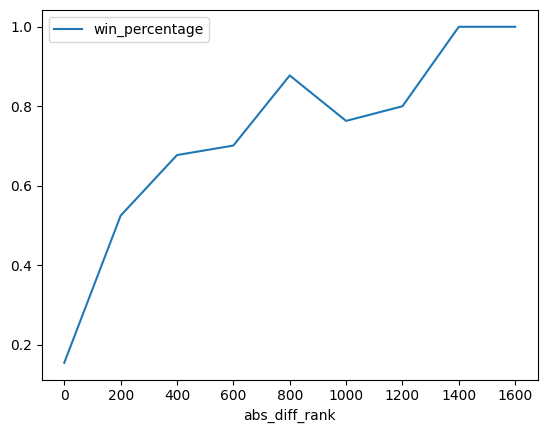

In [8]:
#tallies up black and white favoured games
graph_df['abs_diff_rank'] = graph_df['diff_rank'].apply(lambda x: abs(x+200) if x<0 else x)

abs_graph_df = graph_df.groupby('abs_diff_rank').agg({'win_amount': 'sum', 'game_amount': 'sum'}).reset_index()
abs_graph_df['win_percentage']=abs_graph_df['win_amount']/abs_graph_df['game_amount']

print(abs_graph_df)

abs_graph_df.plot(x='abs_diff_rank', y='win_percentage')

Text(0, 0.5, 'Win Percentage')

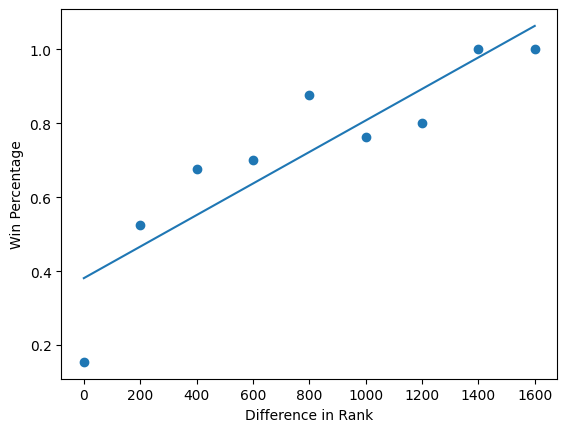

In [ ]:
#try linear line of best fit
plt.scatter(abs_graph_df['abs_diff_rank'], abs_graph_df['win_percentage'])
a, b = np.polyfit(abs_graph_df['abs_diff_rank'], abs_graph_df['win_percentage'], 1)
plt.plot(abs_graph_df['abs_diff_rank'], a*abs_graph_df['abs_diff_rank']+b)
plt.xlabel("Difference in Rank")
plt.ylabel("Win Percentage")

We can draw a conclusion from the line of best fit that generally the win percentage is correlated to the difference in rank. The larger the rank difference, the more likely a player is to win.